### Abstract

The objective is to choose the best model for a given data, thus we need to make several models  with a portion of the data and evaluating the best model possible by choosing the one with the lowest SSE. After choosing the best model is necessary to create a new model with all training data avaiable in order to create outputs for the real data.

# Import Libraries

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures,  StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from tqdm import tqdm

# Import Train Data

In [3]:
N_list = 1000
X_import = np.load("data/Xtrain_Regression1.npy")
Y_import = np.load("data/Ytrain_Regression1.npy")
# create global functions to store the splitted data
X_train,Y_train,X_test,Y_test, X_train_s, X_test_s,Y_train_s,Y_test_s = [], [], [], [], [], [], [], []

for i in range(N_list):
    result = train_test_split(X_import, Y_import, test_size=0.2)
    X_train.append(result[0])
    X_test.append(result[1])
    Y_train.append(result[2])
    Y_test.append(result[3])

    X_train_s.append(StandardScaler().fit_transform(result[0]))
    X_test_s.append(StandardScaler().fit_transform(result[1]))

# Essencial Functions

In [4]:
def split_data(x_import,y_import,test_siz):
    '''Splits the data according to the test_siz fraction'''
    x_train, x_test, y_train, y_test = train_test_split(x_import, y_import, test_size=test_siz)
    return (x_train,y_train,x_test,y_test)

def calc_SSE(y_pred,y):
    '''Calculates the SSE from the predicted data'''
    #return np.sum((y_pred - y)**2)
    return mean_squared_error(y_pred,y)*np.shape(y)[0]

def beta_from_model(model):
    '''Returns the complete beta matrix from the model'''
    beta = model.coef_[0]
    beta[0] = model.intercept_[0]
    return beta 

# Linear Model

In [20]:
def linear_model(x, y):
    '''Creates and returns a simple linear regression model of order 1'''
    LR = LinearRegression()
    LR.fit(x,y)
    return LR

def test_linear_model():
    '''Tests the linear model returning a simple SSE value'''

    SSE_lst, MSE_lst = [], []

    for i in range(N_list):
        model_sl = linear_model(X_train[i], Y_train[i])
        y_pred = model_sl.predict(X_test[i])
        SSE_lst.append(calc_SSE(y_pred, Y_test[i]))
        MSE_lst.append(mean_squared_error(y_pred, Y_test[i]))

    SSE_avg = np.mean(SSE_lst)
    SSE_std = np.std(SSE_lst)
    MSE_avg = np.mean(MSE_lst)
    MSE_std = np.std(MSE_lst)

    return(SSE_avg,SSE_std,MSE_avg,MSE_std)

lin = test_linear_model()
print("Average SSE :", lin[0], "+/-", lin[1])
print("Average MSE :", lin[2], "+/-", lin[3])

Average SSE : 0.2549634313366511 +/- 0.06870504229574272
Average MSE : 0.012748171566832557 +/- 0.003435252114787136


# Polynomial Model

SSE order 1 : 0.2549634313366513 +/- 0.06870504229574277
SSE order 2 : 10.426740142962954 +/- 30.893002160167107
SSE order 3 : 31.003524368749016 +/- 12.0546251319892
SSE order 4 : 83.45919164718333 +/- 35.95687449047499


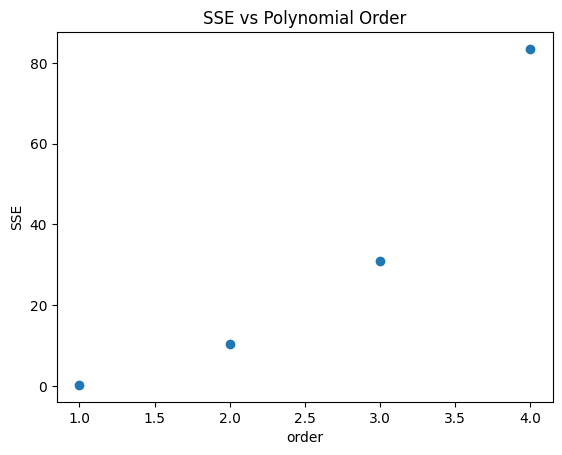

In [6]:
def polynomial_model(x, y, deg):
    '''Creates the polynomial model'''

    poly = PolynomialFeatures(degree=deg, include_bias=True)  
    poly_features = poly.fit_transform(x) 
    poly_reg_model = LinearRegression()  
    poly_reg_model.fit(poly_features, y)
    return poly_reg_model, poly

def test_polynomial_model(deg_max,show_plots=True):
    '''Tests the polynomial model up to deg_max'''

    order_list, SSE, SSE_plt = [i for i in range(1,deg_max+1)], [], []

    def get_avg_sse(i):
        '''Returns the average SSE for a given polynomial degree'''
        SSE_lst = []
        for s in range(N_list):
            (model,poly) = polynomial_model(X_train[s],Y_train[s],i)
            x_test_trans = poly.transform(X_test[s])
            y_pred = model.predict(x_test_trans)
            SSE_lst.append(calc_SSE(y_pred,Y_test[s]))
        return [np.mean(SSE_lst), np.std(SSE_lst)]
        

    for i in range(1,deg_max+1):
        SSE.append(get_avg_sse(i))
        SSE_plt.append(SSE[-1][0])
    
    
    if show_plots:
        plt.scatter(order_list, SSE_plt)
        plt.xlabel('order')
        plt.ylabel('SSE')
        plt.title('SSE vs Polynomial Order')
        
        return SSE, plt
    
    else:
        return SSE


SSE_pol, plot_pol = test_polynomial_model(4,show_plots=True)
for i in range(len(SSE_pol)):
    print("SSE order",i+1,":",SSE_pol[i][0], "+/-", SSE_pol[i][1])
plot_pol.show()

From the plot above we can see that a first order model is the best

# Ridge Model

In [10]:
def ridge_modelcv(x,y,cv):
    param = {
    # Uncoment just on list of alphas at a time and fine tune
    #'alpha':[0.0001, 0.001,0.01,1], #First Run select order -> 0.001 the best
    'alpha':(np.linspace(0.001, 10, 100)), #At this range is random  -8,8
    #'fit_intercept':[True,False],
    #'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'] #,'lbfgs'
    }
    
    model = Ridge()
    search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)
    result = search.fit(x, y)
    return result

def test_ridge_model_scaling(i,pt=True):
    '''This function tests the ridge model'''

    # cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    cv = None
    model = ridge_modelcv(X_train_s[i],Y_train[i],cv)
    y_pred = model.predict(X_test_s[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test[i])
    mse=mean_squared_error(Y_test[i],y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

def test_ridge_model(i,pt=True):
    '''This function tests the ridge model'''

    # cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    cv = None
    model = ridge_modelcv(X_train[i],Y_train[i],cv)
    y_pred = model.predict(X_test[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test[i])
    mse=mean_squared_error(Y_test[i],y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

In [12]:
# Deprecated code

# from tqdm import trange

# TestAlpha = []
# TestScore = []
# TestMSE   = []
# TestSSE   = []

# for i in trange(N_list):
#     best_ridge = test_ridge_model(i,pt=False)

#     TestAlpha.append(best_ridge[3])
#     TestScore.append(best_ridge[0])
#     TestMSE.append(best_ridge[2])
#     TestSSE.append(best_ridge[1])

# print("α   =", np.mean(TestAlpha), "±", np.std(TestAlpha))
# print("R²  =", np.mean(TestScore), "±", np.std(TestScore))
# print("MSE =", np.mean(TestMSE), "±", np.std(TestMSE))
# print("SSE =", np.mean(TestSSE), "±", np.std(TestSSE))
# best_alpha_ridge = np.mean(TestAlpha)

In [25]:
# With scaling
from tqdm import trange
alphalist = np.linspace(start=0.001, stop=10, num=200)
model = RidgeCV(alphas=alphalist)

def test_ridge_model_scaling(i,model, pt=True):
    '''This function tests the ridge model'''
    model.fit(X_train_s[i], Y_train[i])

    y_pred = model.predict(X_test_s[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test[i])
    mse=mean_squared_error(Y_test[i],y_pred)
    alpha=model.alpha_

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.alpha_)
    return r2, sse, mse, alpha

TestAlpha = []
TestScore = []
TestMSE   = []
TestSSE   = []

for i in trange(N_list):
    best_ridge = test_ridge_model_scaling(i,model,pt=False)

    TestAlpha.append(best_ridge[3])
    TestScore.append(best_ridge[0])
    TestMSE.append(best_ridge[2])
    TestSSE.append(best_ridge[1])

print("α   =", np.mean(TestAlpha), "±", np.std(TestAlpha))
print("R²  =", np.mean(TestScore), "±", np.std(TestScore))
print("MSE =", np.mean(TestMSE), "±", np.std(TestMSE))
print("SSE =", np.mean(TestSSE), "±", np.std(TestSSE))

100%|██████████| 1000/1000 [00:47<00:00, 20.92it/s]

α   = 0.05792897989949749 ± 0.028834113977513436
R²  = -0.012729727805821314 ± 0.0009864132847006344
MSE = 0.5935434799799115 ± 0.5587284955771666
SSE = 11.870869599598231 ± 11.174569911543331


In [27]:
# Without scaling
from tqdm import trange
alphalist = np.linspace(start=0.001, stop=0.1, num=100)
model = RidgeCV(alphas=alphalist)

def test_ridge_model(i,model, pt=True):
    '''This function tests the ridge model'''
    model.fit(X_train[i], Y_train[i])

    y_pred = model.predict(X_test[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test[i])
    mse=mean_squared_error(Y_test[i],y_pred)
    alpha=model.alpha_

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.alpha_)
    return r2, sse, mse, alpha

TestAlpha = []
TestScore = []
TestMSE   = []
TestSSE   = []

for i in trange(N_list):
    best_ridge = test_ridge_model(i,model,pt=False)

    TestAlpha.append(best_ridge[3])
    TestScore.append(best_ridge[0])
    TestMSE.append(best_ridge[2])
    TestSSE.append(best_ridge[1])

print("α   =", np.mean(TestAlpha), "±", np.std(TestAlpha))
print("R²  =", np.mean(TestScore), "±", np.std(TestScore))
print("MSE =", np.mean(TestMSE), "±", np.std(TestMSE))
print("SSE =", np.mean(TestSSE), "±", np.std(TestSSE))

best_ridge_alpha = np.mean(TestAlpha)

100%|██████████| 1000/1000 [00:42<00:00, 23.46it/s]

α   = 0.057656000000000006 ± 0.025140438818763686
R²  = -0.012729708937823552 ± 0.0009864866528764137
MSE = 0.012747873439401744 ± 0.0034517949828477903
SSE = 0.2549574687880349 ± 0.06903589965695581


# Lasso Model

In [31]:
def lasso_modelcv(x,y,cvs):
    param = {
    # Uncoment just on list of alphas at a time and fine tune
    #'alpha':[0.0001, 0.001,0.01,1], #First Run select order -> 0.001 the best
    'alpha':(np.logspace(-3, 0, 100)), #At this range is random 
    #'fit_intercept':[True,False]
       }
    
    lasso = Lasso()
    search = GridSearchCV(lasso, param, scoring='r2' ,cv = cvs)
    result = search.fit(x, y)
    return result

def test_lasso_model(i,pt=True):
    '''This function tests the ridge model'''

    cv = None
    # cv =RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    model = lasso_modelcv(X_train[i],Y_train[i],cv)
    y_pred = model.predict(X_test[i])
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test[i])
    mse=mean_squared_error(Y_test[i],y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

best_lasso_alpha=test_lasso_model(0)[3]

R2: 0.9970412528248165
SSE: 0.29720417943519795
MSE 0.014860208971759898
Best Hyperparameters: {'alpha': 0.001}


In [34]:
# Deprecated Code
# from tqdm import trange

# TestAlpha = []
# TestScore = []
# TestMSE   = []
# TestSSE   = []

# for i in trange(100):
#     best_lasso = test_lasso_model(i,pt=False)

#     TestAlpha.append(best_lasso[3])
#     TestScore.append(best_lasso[0])
#     TestMSE.append(best_lasso[2])
#     TestSSE.append(best_lasso[1])

# print("α   =", np.mean(TestAlpha), "±", np.std(TestAlpha))
# print("R²  =", np.mean(TestScore), "±", np.std(TestScore))
# print("MSE =", np.mean(TestMSE), "±", np.std(TestMSE))
# print("SSE =", np.mean(TestSSE), "±", np.std(TestSSE))

In [44]:
# Without scaling
from tqdm import trange
alphalist = np.linspace(start=0.001, stop=0.1, num=100)
model = LassoCV(alphas=alphalist)

def test_lasso_model(i,model, pt=True):
    '''This function tests the lasso model'''
    model.fit(X_train[i], np.ravel(Y_train[i]))
    y_pred = model.predict(X_test[i])
    sse=calc_SSE(y_pred,Y_test[i])
    mse=mean_squared_error(Y_test[i],y_pred)
    alpha=model.alpha_

    if pt==True:
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.alpha_)
    return sse, mse, alpha

TestAlpha = []
TestScore = []
TestMSE   = []
TestSSE   = []

for i in trange(N_list):
    best_lasso = test_lasso_model(i,model,pt=False)

    TestAlpha.append(best_lasso[2])
    TestMSE.append(best_lasso[1])
    TestSSE.append(best_lasso[0])

print("α   =", np.mean(TestAlpha), "±", np.std(TestAlpha))
print("MSE =", np.mean(TestMSE), "±", np.std(TestMSE))
print("SSE =", np.mean(TestSSE), "±", np.std(TestSSE))

best_lasso_alpha = np.mean(TestAlpha)

100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]

α   = 0.0031390000000000003 ± 0.00200591101497549
MSE = 0.012787416773737887 ± 0.003644029854051399
SSE = 0.2557483354747577 ± 0.07288059708102798


# Comparing Linear, Ridge and Lasso

In [49]:
from tqdm import tqdm
def compare_lin_rid_las(alpha_list):
    MSE_ridge, MSE_lasso, MSE_linear = [], [], []
    for alpha in tqdm(alpha_list):

        for i in range(N_list):
         
            MSE_ridge_i, MSE_lasso_i, MSE_linear_i = [], [], []
            #Linear
            linear = LinearRegression()
            linear.fit(X_train[i],Y_train[i])
            y_linear = linear.predict(X_test[i])
            MSE_linear_i.append(mean_squared_error(Y_test[i],y_linear))

            #Ridge
            ridge = Ridge(alpha=alpha)
            ridge_model = ridge.fit(X_train[i],Y_train[i])
            y_ridge = ridge_model.predict(X_test[i])
            MSE_ridge_i.append(mean_squared_error(Y_test[i],y_ridge))

            # Lasso
            lasso = Lasso(alpha = alpha)
            lasso_model = lasso.fit(X_train[i],Y_train[i])
            y_lasso = lasso_model.predict(X_test[i])
            MSE_lasso_i.append(mean_squared_error(Y_test[i],y_lasso))

        MSE_linear.append(np.mean(MSE_linear_i))
        MSE_ridge.append(np.mean(MSE_ridge_i))
        MSE_lasso.append(np.mean(MSE_lasso_i))

    plt.plot(alpha_list, MSE_linear, color='r', label='Linear (No relation to alpha)')
    plt.plot(alpha_list,MSE_ridge, color='g', label='Ridge')
    plt.plot(alpha_list,MSE_lasso,  color='b', label='Lasso')

    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.title("Regression Method Comparison")
    
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
    
    # To load the display window
    plt.show()

#compare_lin_rid_las(np.logspace(-3, -0.9, 50))
# Remove comment to see plot

As we can see, the smaller average MSE on 1000 runs is the Ridge Model with a alpha value of 0.057656000000000006 without feature scaling

## Conclusions

Let's assume Ridge is the best model due to a marginal difference in SSE

In [53]:
x_eval_import = np.load("data/Xtest_Regression1.npy")
ridge = Ridge(alpha = best_ridge_alpha)
ridge_model = ridge.fit(X_import,Y_import)
y_pred_finalissimo = ridge_model.predict(x_eval_import)
print(np.shape(y_pred_finalissimo))
np.save('data/predictions_t1.npy', y_pred_finalissimo)

(1000, 1)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=25889058-66de-44c8-ad64-ee695f6c1052' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>